In [16]:
import pandas as pd
import numpy as np
from collections import defaultdict 
import sys
import os
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import keras 
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM, Flatten, Lambda
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from keras.preprocessing.text import Tokenizer

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from keras.utils.vis_utils import plot_model

In [17]:
ADDR = '/nfs_home/nbhardwaj/data/rds_final/'
w_ADDR = '/nfs_home/nbhardwaj/model_weights/finalwts/'

In [13]:
from sklearn.preprocessing import LabelEncoder

class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        m = {}
        for x in self.label_encoder.classes_:
            m[x] = True
        for ind, y in enumerate(new_data_list):
            if(m.get(y) is None):
                new_data_list[ind] = 'Unknown'
#         for unique_item in np.unique(data_list):
#             if unique_item not in self.label_encoder.classes_:
#                 new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]
        return self.label_encoder.transform(new_data_list)
    

In [14]:
def create_model(embed_size = 10):
    inp1 = Input(shape = (1,))
    inp2 = Input(shape = (1,))
    # inp3 = Input(shape = (1,))

    embed1 = Embedding(len(le_inst.classes_), embed_size, input_length = 1)(inp1)
    embed2 = Embedding(len(le_delta.classes_), embed_size, input_length = 1)(inp2)

    merged_inp = keras.layers.concatenate([embed1, embed2], axis = 1)
    merged_inp = Flatten()(merged_inp)
    # merged_inp = keras.layers.concatenate([merged_inp, inp3])
    
#     out = LSTM(64)(merged_inp)
    out = Dense(32, activation = 'relu')(merged_inp)
    out = Dense(8, activation = 'softmax')(out)

    model = Model([inp1, inp2], out)
    return model

In [15]:
files = [510
#           , 511, 526, 600, 602, 620, 623, 625, 631, 641, 648, 657
         ]
sets = [0
#     x for x in range(64)
]
df_m = pd.DataFrame(columns = ['fname', 'set', 'train_acc', 'test_acc', 'len', 'inst_v', 'delt_v'])
for fname in files:
    cw_ADDR = w_ADDR+str(fname)+'/'
    for cset in sets:
        if(not os.path.isdir(cw_ADDR)):
            os.system("mkdir "+cw_ADDR)
            
        df = pd.read_csv(ADDR+str(fname)+'_'+str(cset)+'.csv', index_col = [0], usecols = [0,2,7,8])
        df.Instruction = df.Instruction.astype('str')
        df.delta = df.delta.astype('float')

        X = df[['Instruction', 'delta']].values[1:]
        y = df[['label']].values[1:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
        print("--------------------split done---------------------")
        le_inst = LabelEncoderExt()
        le_inst.fit(X_train[:, 0])
        le_delta = LabelEncoderExt()
        le_delta.fit(X_train[:, 1])
        print("----------------labels done----------------------")
        X_train[:, 0] = le_inst.transform(X_train[:, 0])
        X_train[:, 1] = le_delta.transform(X_train[:, 1])
        print("--------")

        X_test[:, 0] = le_inst.transform(X_test[:, 0])
        X_test[:, 1] = le_delta.transform(X_test[:, 1])
        print("-------------------labels transformed---------------------")
        filepath = cw_ADDR+str(fname)+'_'+str(cset)+'.hdf5'

        if(os.path.isfile(filepath)):
            model = load_model(filepath)
            print("using loaded model", filepath)
        else:
            model = create_model()
            model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
     
#         es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)
#         mc = ModelCheckpoint(filepath, monitor = 'val_accuracy', save_best_only = True, mode = 'max')
#         history = model.fit([X_train[:, 0], X_train[:, 1]], to_categorical(y_train), epochs = 50, 
#                   validation_split = 0.2, use_multiprocessing = True, verbose = 2, callbacks = [es, mc], batch_size = 256)

        print("------------training done------------")
    #     model.save_weights(filepath)
        t_ac = model.evaluate([X_test[:, 0], X_test[:, 1]], to_categorical(y_test), verbose = 2)[1]
        tr_ac = model.evaluate([X_train[:, 0], X_train[:, 1]], to_categorical(y_train), verbose = 2)[1]
        
        # need to reduce len to test_size later
#         df_m.loc[len(df_m)] = [fname, cset, tr_ac, t_ac, len(df), len(le_inst.classes_), len(le_delta.classes_)]

        print("--------------done processing for set---------->", cset)
        print( '|| accuracy||', tr_ac, t_ac)
        print("inst vocal", len(le_inst.classes_), "|| delta vocal->", len(le_delta.classes_))
        print("____________________________________________________________________________________________________")
#     df_m.to_csv(cw_ADDR+'results.csv')
    print("$$$$$$$ done for file ||------------>", fname)
# df_m.to_csv(w_ADDR+'results.csv')
print("---------ALL DONE___________")

--------------------split done---------------------
----------------labels done----------------------
--------
-------------------labels transformed---------------------
using loaded model /nfs_home/nbhardwaj/model_weights/finalwts/510/510_0.hdf5
------------training done------------
--------------done processing for set----------> 0
|| accuracy|| 0.866525411605835 0.866209864616394
inst vocal 212 || delta vocal-> 28897
____________________________________________________________________________________________________
$$$$$$$ done for file ||------------> 510
---------ALL DONE___________


In [ ]:
model.evaluate()

In [34]:
# history.history.keys()

dict_keys(['accuracy', 'val_accuracy', 'val_loss', 'loss'])

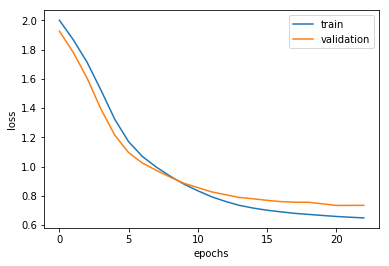

In [35]:
# plt.plot(history.history['loss'], label = 'train')
# plt.plot(history.history['val_loss'] , label = 'validation')
# plt.legend()
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.show()

In [20]:
!cd w_ADDR

In [36]:
addr_l = [510  ,511 , 526,  600 , 602,  620,  631,  641, 648]

In [30]:
for addr in addr_l:
    if(not os.path.isfile(w_ADDR+str(addr)+'/'+'results.csv')):
        print(addr)

In [37]:
m = {}
inst_voc = {}
delt_voc = {}
for addr in addr_l:
    df = pd.read_csv(w_ADDR+str(addr)+'/results.csv')
    inst_voc[addr] = np.mean(df.inst_v.values)
    delt_voc[addr] = np.mean(df.delt_v.values)
    m[addr] = 100*np.dot(df.test_acc.values, df.len.values)/np.sum(df.len.values)

In [38]:
print(inst_voc)

{641: 703.0625, 648: 532.5703125, 510: 209.75, 631: 1218.859375, 600: 743.546875, 602: 35388.53125, 620: 1032.96875, 526: 813.1015625, 511: 1046.171875}


In [39]:
print(delt_voc)

{641: 907.171875, 648: 458.4453125, 510: 26900.46875, 631: 7546.75, 600: 2086.7760416666665, 602: 30183.9375, 620: 77553.9375, 526: 2171.359375, 511: 700.84375}


In [40]:
print(m)

{641: 93.3809256118209, 648: 94.70002364929236, 510: 86.62580390358154, 631: 91.29054379538019, 600: 91.01475624079966, 602: 88.67581705370743, 620: 85.80601742950273, 526: 91.09905508984875, 511: 91.48333858118957}


In [45]:
from collections import OrderedDict
delt_voc = OrderedDict(sorted(delt_voc.items()))
inst_voc = OrderedDict(sorted(inst_voc.items()))

In [42]:
from collections import OrderedDict
m = OrderedDict(sorted(m.items()))

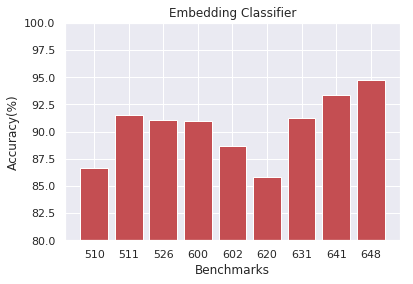

In [43]:
import seaborn as sns
sns.set()
plt.bar(range(len(m)), list(m.values()), align = 'center', color = 'r')
plt.xticks(range(len(m)), list(m.keys()))
plt.ylim((80, 100))
plt.xlabel('Benchmarks')
plt.ylabel('Accuracy(%)')
plt.title('Embedding Classifier')
plt.show()



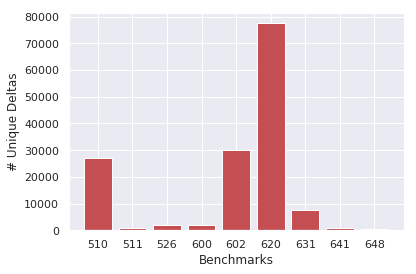

In [46]:

plt.bar(range(len(delt_voc)), list(delt_voc.values()), align = 'center', color = 'r')
plt.xticks(range(len(delt_voc)), list(delt_voc.keys()))
# plt.ylim((80, 100))
plt.xlabel('Benchmarks')
plt.ylabel('# Unique Deltas')
plt.show()



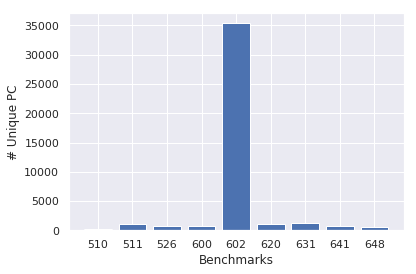

In [47]:

plt.bar(range(len(inst_voc)), list(inst_voc.values()), align = 'center', color = 'b')
plt.xticks(range(len(inst_voc)), list(inst_voc.keys()))
# plt.ylim((80, 100))
plt.xlabel('Benchmarks')
plt.ylabel('# Unique PC')
plt.show()



In [ ]:
# how to load the stored model

# from keras.models import load_model
# saved_model = load_model(filepath)
# tr_ac = model.evaluate([X_train[:, 0], X_train[:, 1], X_train[:, 2]], to_categorical(y_train))[1]
# print("train acc--->", tr_ac)